# Présentation du travail pour le datachallenge
Víctor Camps, Aldric Bahna

## Exploration des données

Import des bibliothèques utiles

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings

Chemin vers les données

In [14]:
data_dir = Path('data')
x_train_dir = data_dir / 'x_train_images'
x_test_dir = data_dir / 'x_test_images'
y_train_file = data_dir / 'y_train_labels' / 'Y_train_T9NrBYo.csv'

In [15]:
print(f"Data directory: {data_dir}")
print(f"Training images dir: {x_train_dir}")
print(f"Labels file: {y_train_file}")

Data directory: data
Training images dir: data\x_train_images
Labels file: data\y_train_labels\Y_train_T9NrBYo.csv


In [16]:
# Load training labels from CSV
print("Loading training labels...")
y_train = pd.read_csv(y_train_file, index_col=0)
print(f"Loaded {len(y_train)} training patches")
print(f"\nDataset shape: {y_train.shape}")
print(f"Sample patch names: {list(y_train.index[:5])}")
print(f"\nFirst few values of first patch:")
print(y_train.iloc[0, :20])

Loading training labels...
Loaded 4410 training patches

Dataset shape: (4410, 43520)
Sample patch names: ['well_2_section_22_patch_1', 'well_6_section_10_patch_3', 'well_1_section_10_patch_6', 'well_6_section_10_patch_15', 'well_1_section_14_patch_6']

First few values of first patch:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    2
19    2
Name: well_2_section_22_patch_1, dtype: int64


## Accès aux labels des patches
Accès à tous les labels en une seule fois

In [17]:
# Accès à tous les labels à la fois
labels_patches = {}
for index_, values in y_train.iterrows():
    labels_patches[index_] = np.array([v for v in values if v != -1]).reshape(160, -1)

print(f"Total number of patches: {len(labels_patches)}")
print(f"Example patch names: {list(labels_patches.keys())[:5]}")
print(f"\nShape of each label: {next(iter(labels_patches.values())).shape}")

Total number of patches: 4410
Example patch names: ['well_2_section_22_patch_1', 'well_6_section_10_patch_3', 'well_1_section_10_patch_6', 'well_6_section_10_patch_15', 'well_1_section_14_patch_6']

Shape of each label: (160, 272)


Accès à un seul patch (exemple avec le premier patch disponible)

In [18]:
# Accès à un seul patch label
patch_name = y_train.index[0]
single_patch_label = np.array([v for v in y_train.loc[patch_name] if v != -1]).reshape(160, -1)
print(f"Patch name: {patch_name}")
print(f"Shape of patch label: {single_patch_label.shape}")
print(f"\nFirst few rows:\n{single_patch_label[:5, :5]}")

Patch name: well_2_section_22_patch_1
Shape of patch label: (160, 272)

First few rows:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


### Visualisation des images d'entraînement (.npy)

In [19]:
# Lister les images d'entraînement disponibles
train_images = sorted(list(x_train_dir.glob('*.npy')))
print(f"Nombre d'images d'entraînement: {len(train_images)}")
print(f"\nPremières images:")
for img_path in train_images[:5]:
    print(f"  - {img_path.name}")

Nombre d'images d'entraînement: 4410

Premières images:
  - well_1_section_0_patch_0.npy
  - well_1_section_0_patch_1.npy
  - well_1_section_0_patch_10.npy
  - well_1_section_0_patch_11.npy
  - well_1_section_0_patch_12.npy


In [20]:
# Charger et afficher les propriétés d'une image
image_path = train_images[0]
image = np.load(image_path)

print(f"\nImage: {image_path.name}")
print(f"Shape: {image.shape}")
print(f"Data type: {image.dtype}")
print(f"Min value: {image.min()}")
print(f"Max value: {image.max()}")
print(f"Mean value: {image.mean():.2f}")


Image: well_1_section_0_patch_0.npy
Shape: (160, 272)
Data type: int16
Min value: -330
Max value: 345
Mean value: 0.06


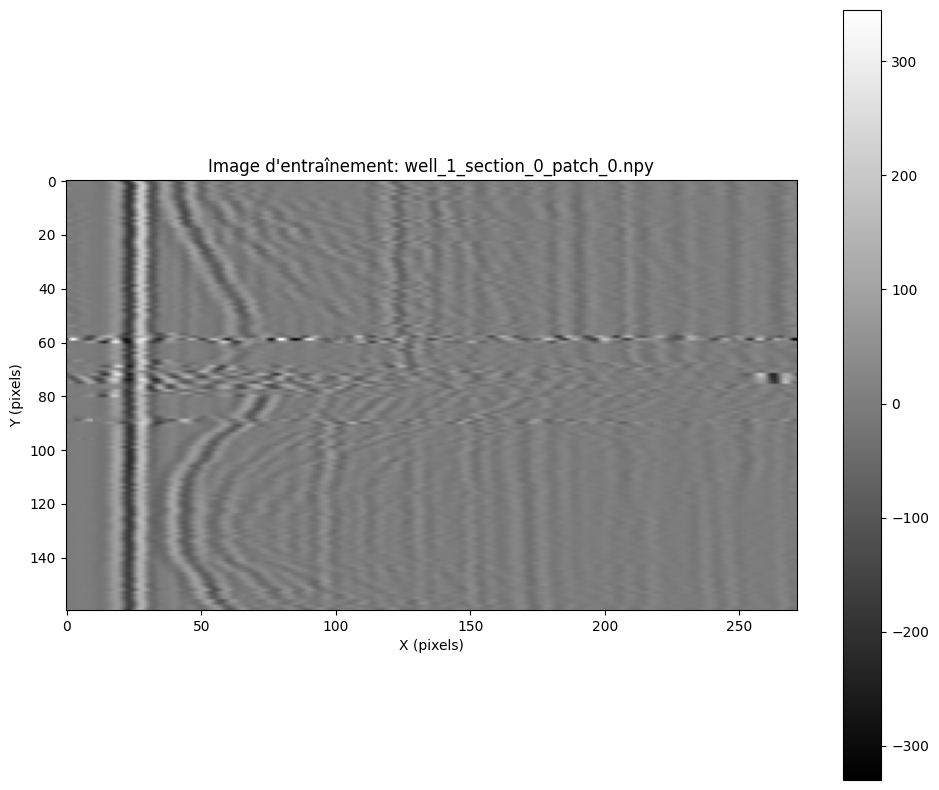

In [21]:
# Visualiser l'image
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(image, cmap='gray')
ax.set_title(f"Image d'entraînement: {image_path.name}")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Visualisation des données d'entraînement
L'objectif ici est de comprendre ce que l'on veut. On observe l'attendu, différencier entre plusieurs classes ce que l'on voit avec l'ultrason

In [27]:
# Importer le DataLoader
from deep_datachallenge.data_loader import DataLoader

# Initialiser le DataLoader
loader = DataLoader(data_dir='data')
print("DataLoader initialisé")

Chargement des labels d'entraînement...
4410 patches d'entraînement chargés
DataLoader initialisé


In [29]:
# Charger une paire image-masque aléatoire
patch_example = loader.get_random_patch()
image, mask = loader.load_pair(patch_example, phase='train')

print(f"Patch sélectionné: {patch_example}")
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"\nClasses dans le masque: {np.unique(mask)}")

Patch sélectionné: well_2_section_10_patch_12
Image shape: (160, 272)
Mask shape: (160, 272)

Classes dans le masque: [0 1 2]


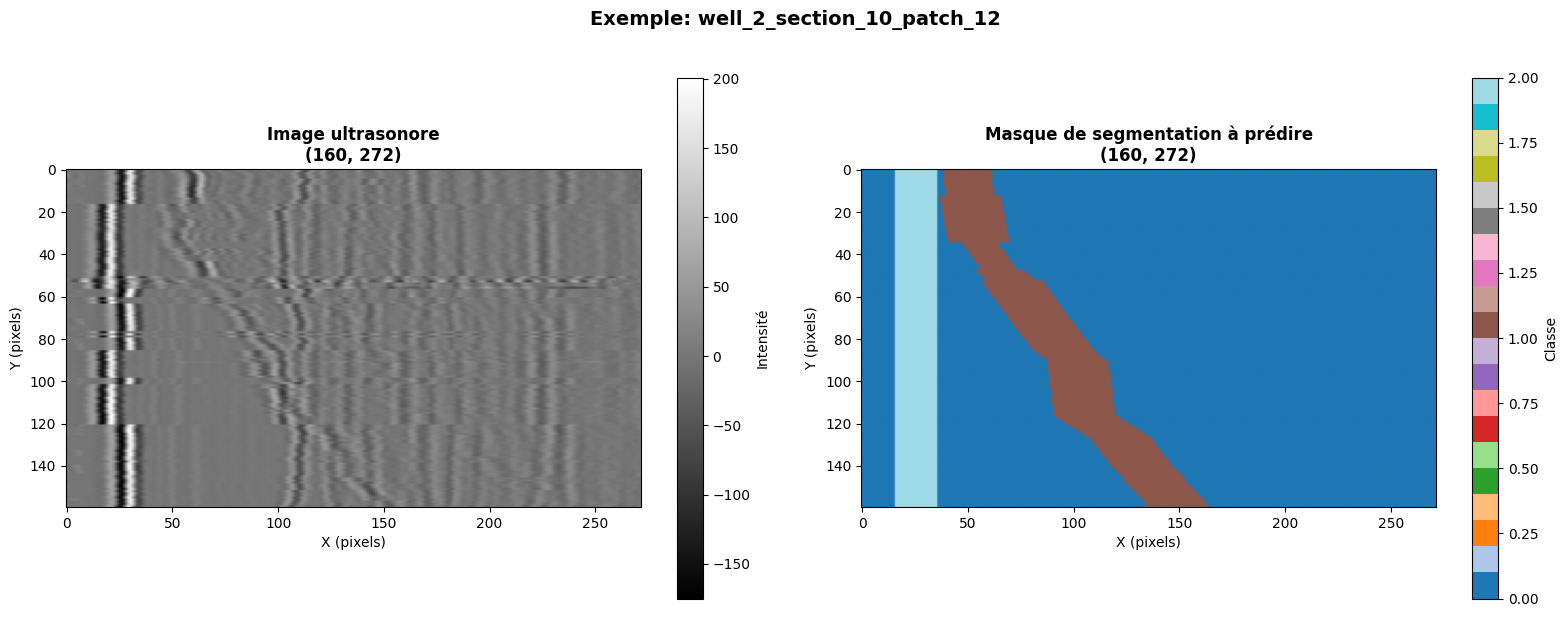


OBJECTIF DU MODÈLE:
Entrée: Image ultrasonore 2D de shape (160, 272)
Sortie: Masque de segmentation de shape (160, 272)
Classes à segmenter: [0 1 2]


In [30]:
# Afficher côte à côte l'image et le masque attendu
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Image d'entrée
im1 = axes[0].imshow(image, cmap='gray')
axes[0].set_title(f"Image ultrasonore\n{image.shape}", fontsize=12, fontweight='bold')
axes[0].set_xlabel("X (pixels)")
axes[0].set_ylabel("Y (pixels)")
plt.colorbar(im1, ax=axes[0], label='Intensité')

# Masque attendu (ce qu'on doit prédire)
im2 = axes[1].imshow(mask, cmap='tab20')
axes[1].set_title(f"Masque de segmentation à prédire\n{mask.shape}", fontsize=12, fontweight='bold')
axes[1].set_xlabel("X (pixels)")
axes[1].set_ylabel("Y (pixels)")
cbar = plt.colorbar(im2, ax=axes[1], label='Classe')

plt.suptitle(f"Exemple: {patch_example}", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OBJECTIF DU MODÈLE:")
print("="*60)
print(f"Entrée: Image ultrasonore 2D de shape {image.shape}")
print(f"Sortie: Masque de segmentation de shape {mask.shape}")
print(f"Classes à segmenter: {np.unique(mask)}")
print("="*60)